# \*\*\[GODE\]\*\*final GODE code

SEOYEON CHOI  
2023-10-20

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random

import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML
import plotly.graph_objects as go
import copy 

import tqdm
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector 

from pygsp import graphs, filters, plotting, utils

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc

In [2]:
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.cblof import CBLOF
from pyod.models.ocsvm import OCSVM
from pyod.models.mcd import MCD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.abod import ABOD
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.sos import SOS
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.lscp import LSCP

2023-11-27 13:23:42.982919: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

# Class

In [3]:
class Conf_matrx:
    def __init__(self,original,compare):
        self.original = original
        self.compare = compare
    def conf(self,name):
        self.name = name
        self.conf_matrix = confusion_matrix(self.original, self.compare)
        
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
        for i in range(self.conf_matrix.shape[0]):
            for j in range(self.conf_matrix.shape[1]):
                ax.text(x=j, y=i,s=self.conf_matrix[i, j], va='center', ha='center', size='xx-large')
        plt.xlabel('Predictions', fontsize=18)
        plt.ylabel('Actuals', fontsize=18)
        plt.title('Confusion Matrix of ' + str(name), fontsize=18)
        plt.show()
        
        self.acc = accuracy_score(self.original, self.compare)
        self.pre = precision_score(self.original, self.compare)
        self.rec = recall_score(self.original, self.compare)
        self.f1 = f1_score(self.original, self.compare)
        
        print('Accuracy: %.3f' % self.acc)
        print('Precision: %.3f' % self.pre)
        print('Recall: %.3f' % self.rec)
        print('F1 Score: %.3f' % self.f1)

In [4]:
class Linear:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=20): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)

In [5]:
class Orbit:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)

In [6]:
class BUNNY:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.z = df.z.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.noise = df.noise.to_numpy()
        self.fnoise = self.f + self.noise
        self.W = _W
        self.n = len(self.f)
        self.theta= None
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.fnoise # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.power),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fnoise = self.fnoise)
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f + self.df.noise - self.df.fHat)

In [7]:
tab_linear = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])
tab_bunny = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])

# Linear

In [8]:
np.random.seed(6)
epsilon = np.around(np.random.normal(size=1000),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-7, -5, 25).round(15), np.random.uniform(5, 7, 25).round(15), np.repeat(0, 950))), 1000)
eta = signal + epsilon
outlier_true_linear= signal.copy()
outlier_true_linear = list(map(lambda x: 1 if x!=0 else 0,outlier_true_linear))

In [9]:
x_1 = np.linspace(0,2,1000)
y1_1 = 5 * x_1
y_1 = y1_1 + eta # eta = signal + epsilon
_df=pd.DataFrame({'x':x_1, 'y':y_1})

In [10]:
w=np.zeros((1000,1000))
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

## GODE_Linear

In [11]:
_Linear = Linear(_df)
_Linear.fit(sd=20)

In [12]:
outlier_GODE_linear_old = (_Linear.df['Residual']**2).tolist()
sorted_data = sorted(outlier_GODE_linear_old,reverse=True)
index = int(len(sorted_data) * 0.05)
five_percent = sorted_data[index]
outlier_GODE_linear = list(map(lambda x: 1 if x > five_percent else 0,outlier_GODE_linear_old))

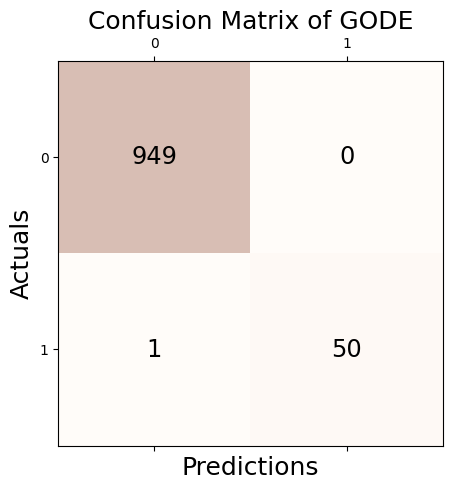

Accuracy: 0.999
Precision: 1.000
Recall: 0.980
F1 Score: 0.990

In [13]:
_conf = Conf_matrx(outlier_true_linear,outlier_GODE_linear)
_conf.conf('GODE')

In [14]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.999
Precision(TP / TP + FP): 1.000
Recall(TP / TP + FN): 0.980
F1 Score(2*precision*recall/precision+recall): 0.990

In [15]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,outlier_GODE_linear_old)

In [16]:
auc(fpr, tpr)

In [17]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## LOF_Linear

In [18]:
np.random.seed(77)
clf = LOF(contamination=0.05)
clf.fit(_df[['x', 'y']])

In [19]:
outlier_LOF_one = list(clf.labels_)

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)

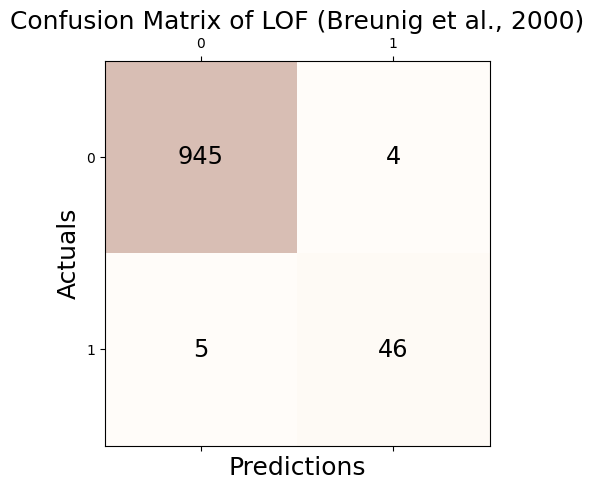

Accuracy: 0.991
Precision: 0.920
Recall: 0.902
F1 Score: 0.911

In [20]:
_conf = Conf_matrx(outlier_true_linear,clf.fit_predict(_df))
_conf.conf("LOF (Breunig et al., 2000)")

In [21]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.991
Precision(TP / TP + FP): 0.920
Recall(TP / TP + FN): 0.902
F1 Score(2*precision*recall/precision+recall): 0.911

In [22]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

In [23]:
auc(fpr, tpr)

In [24]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## KNN_Linear

In [25]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['x', 'y']])

In [26]:
outlier_KNN_one = list(clf.labels_)

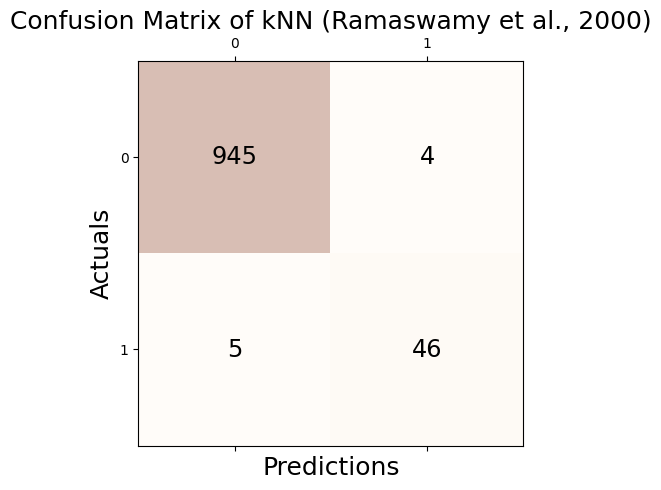

Accuracy: 0.991
Precision: 0.920
Recall: 0.902
F1 Score: 0.911

In [27]:
_conf = Conf_matrx(outlier_true_linear,outlier_KNN_one)
_conf.conf("kNN (Ramaswamy et al., 2000)")

In [28]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.991
Precision(TP / TP + FP): 0.920
Recall(TP / TP + FN): 0.902
F1 Score(2*precision*recall/precision+recall): 0.911

In [29]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

In [30]:
auc(fpr, tpr)

In [31]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## CBLOF_Linear

In [32]:
clf = CBLOF(contamination=0.05,random_state=77)
clf.fit(_df[['x', 'y']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)

In [33]:
outlier_CBLOF_one = list(clf.labels_)

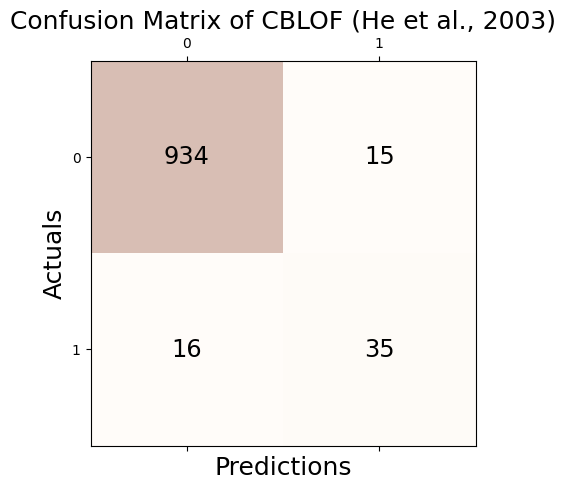

Accuracy: 0.969
Precision: 0.700
Recall: 0.686
F1 Score: 0.693

In [34]:
_conf = Conf_matrx(outlier_true_linear,outlier_CBLOF_one)
_conf.conf("CBLOF (He et al., 2003)")

In [35]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.969
Precision(TP / TP + FP): 0.700
Recall(TP / TP + FN): 0.686
F1 Score(2*precision*recall/precision+recall): 0.693

In [36]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

In [37]:
auc(fpr, tpr)

In [38]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## OCSVM_Linear

In [39]:
np.random.seed(77)
clf = OCSVM(nu=0.05)
clf.fit(_df)

In [40]:
outlier_OSVM_one = list(clf.predict(_df))

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(

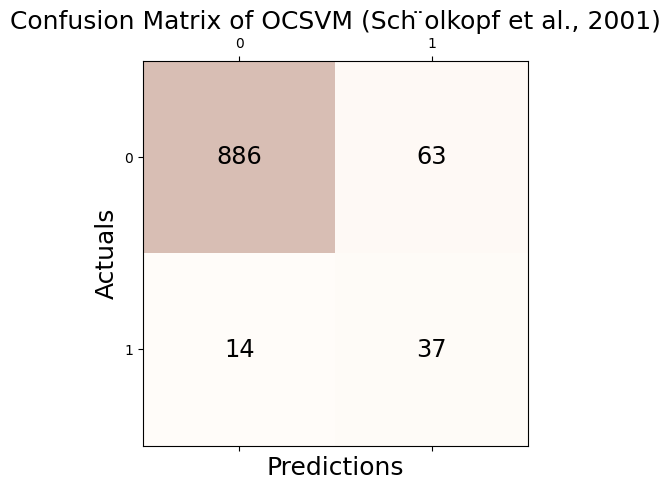

Accuracy: 0.923
Precision: 0.370
Recall: 0.725
F1 Score: 0.490

In [41]:
_conf = Conf_matrx(outlier_true_linear,outlier_OSVM_one)
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

In [42]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.923
Precision(TP / TP + FP): 0.370
Recall(TP / TP + FN): 0.725
F1 Score(2*precision*recall/precision+recall): 0.490

In [43]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(

In [44]:
auc(fpr, tpr)

In [45]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## MCD_Linear

In [46]:
clf = MCD(contamination=0.05, random_state = 77)
clf.fit(_df[['x', 'y']])

In [47]:
outlier_MCD_one = list(clf.labels_)

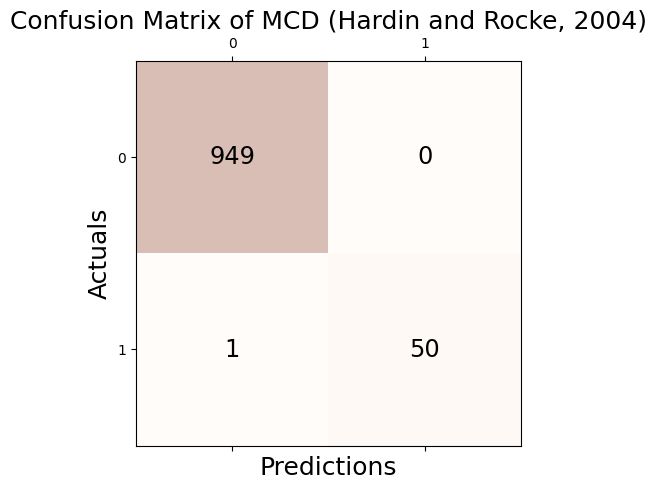

Accuracy: 0.999
Precision: 1.000
Recall: 0.980
F1 Score: 0.990

In [48]:
_conf = Conf_matrx(outlier_true_linear,outlier_MCD_one)
_conf.conf("MCD (Hardin and Rocke, 2004)")

In [49]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.999
Precision(TP / TP + FP): 1.000
Recall(TP / TP + FN): 0.980
F1 Score(2*precision*recall/precision+recall): 0.990

In [50]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

In [51]:
auc(fpr, tpr)

In [52]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## Feature Bagging_Linear

In [53]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y']])

In [54]:
outlier_FeatureBagging_one = list(clf.labels_)

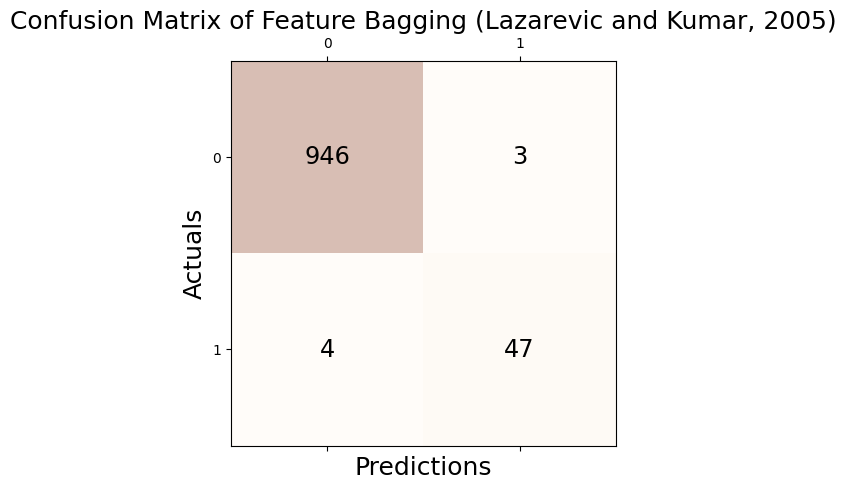

Accuracy: 0.993
Precision: 0.940
Recall: 0.922
F1 Score: 0.931

In [55]:
_conf = Conf_matrx(outlier_true_linear,outlier_FeatureBagging_one)
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

In [56]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.993
Precision(TP / TP + FP): 0.940
Recall(TP / TP + FN): 0.922
F1 Score(2*precision*recall/precision+recall): 0.931

In [57]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

In [58]:
auc(fpr, tpr)

In [59]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## ABOD_Linear

In [60]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y']])

In [61]:
outlier_ABOD_one = list(clf.labels_)

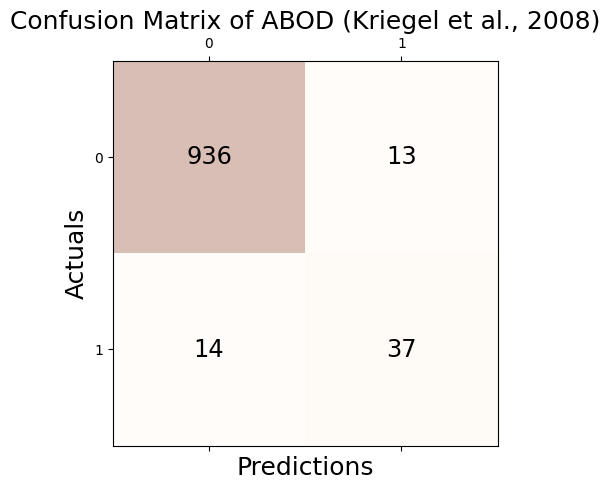

Accuracy: 0.973
Precision: 0.740
Recall: 0.725
F1 Score: 0.733

In [62]:
_conf = Conf_matrx(outlier_true_linear,outlier_ABOD_one)
_conf.conf("ABOD (Kriegel et al., 2008)")

In [63]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.973
Precision(TP / TP + FP): 0.740
Recall(TP / TP + FN): 0.725
F1 Score(2*precision*recall/precision+recall): 0.733

In [64]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

In [65]:
auc(fpr, tpr)

In [66]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## IForest_Linear

In [67]:
clf = IForest(contamination=0.05,random_state=77)
clf.fit(_df[['x', 'y']])

In [68]:
outlier_IForest_one = list(clf.labels_)

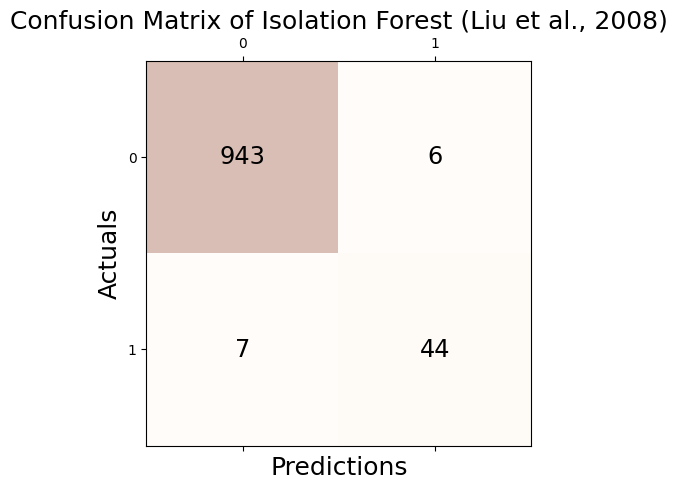

Accuracy: 0.987
Precision: 0.880
Recall: 0.863
F1 Score: 0.871

In [69]:
_conf = Conf_matrx(outlier_true_linear,outlier_IForest_one)
_conf.conf("Isolation Forest (Liu et al., 2008)")

In [70]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.987
Precision(TP / TP + FP): 0.880
Recall(TP / TP + FN): 0.863
F1 Score(2*precision*recall/precision+recall): 0.871

In [71]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(

In [72]:
auc(fpr, tpr)

In [73]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## HBOS_Linear

In [74]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['x', 'y']])

In [75]:
outlier_HBOS_one = list(clf.labels_)

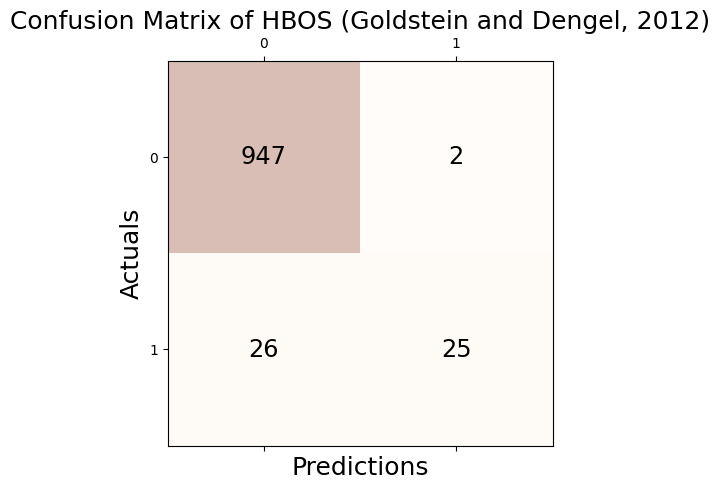

Accuracy: 0.972
Precision: 0.926
Recall: 0.490
F1 Score: 0.641

In [76]:
_conf = Conf_matrx(outlier_true_linear,outlier_HBOS_one)
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

In [77]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.972
Precision(TP / TP + FP): 0.926
Recall(TP / TP + FN): 0.490
F1 Score(2*precision*recall/precision+recall): 0.641

In [78]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

In [79]:
auc(fpr, tpr)

In [80]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## SOS_Linear

In [81]:
np.random.seed(77)
clf = SOS(contamination=0.05)
clf.fit(_df[['x', 'y']])

In [82]:
outlier_SOS_one = list(clf.labels_)

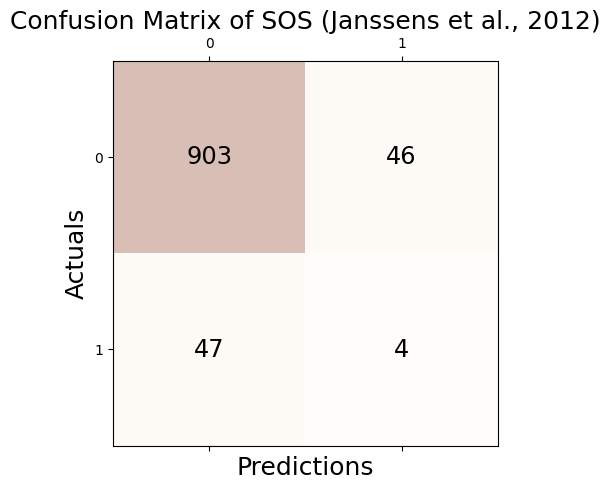

Accuracy: 0.907
Precision: 0.080
Recall: 0.078
F1 Score: 0.079

In [83]:
_conf = Conf_matrx(outlier_true_linear,outlier_SOS_one)
_conf.conf("SOS (Janssens et al., 2012)")

In [84]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.907
Precision(TP / TP + FP): 0.080
Recall(TP / TP + FN): 0.078
F1 Score(2*precision*recall/precision+recall): 0.079

In [85]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

In [86]:
auc(fpr, tpr)

In [87]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## SO_GAAL_Linear

In [88]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

In [89]:
outlier_SO_GAAL_one = list(clf.labels_)

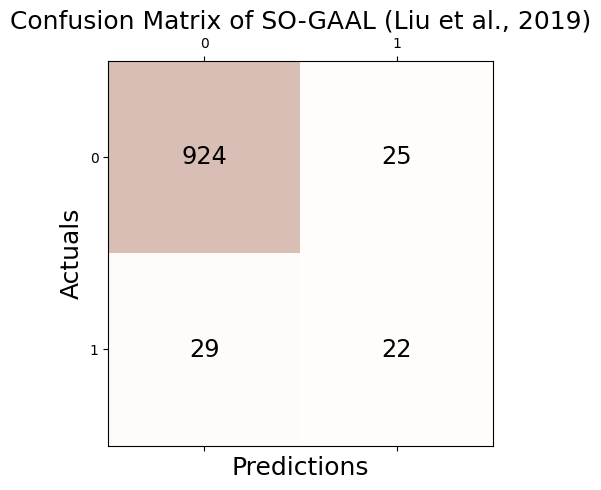

Accuracy: 0.946
Precision: 0.468
Recall: 0.431
F1 Score: 0.449

In [90]:
_conf = Conf_matrx(outlier_true_linear,outlier_SO_GAAL_one)
_conf.conf("SO-GAAL (Liu et al., 2019)")

In [91]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.946
Precision(TP / TP + FP): 0.468
Recall(TP / TP + FN): 0.431
F1 Score(2*precision*recall/precision+recall): 0.449

In [92]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

32/32 [==============================] - 0s 823us/step

In [93]:
auc(fpr, tpr)

In [94]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## MO_GAAL_Linear

In [95]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 1 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 2 of 60

Testing for epoch 2 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 2 index 2:
32/32 [==============================] - 0s 799us/step
Epoch 3 of 60

Testing for epoch 3 index 1:
32/32 [==============================] - 0s 590us/step

Testing for epoch 3 index 2:
32/32 [==============================] - 0s 799us/step
Epoch 4 of 60

Testing for epoch 4 index 1:
32/32 [==============================] - 0s 576us/step

Testing for epoch 4 index 2:
32/32 [==============================] - 0s 574us/step
Epoch 5 of 60

Testing for epoch 5 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 5 index 2:
32/32 [==============================] - 0s 588us/step
Epoch 6 of 60

Testing for epoch 6 index 1:
32/32 [==============================] - 0s 

In [96]:
outlier_MO_GAAL_one = list(clf.labels_)

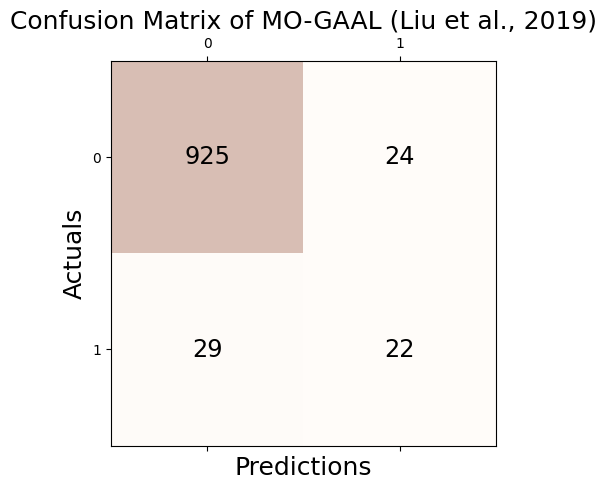

Accuracy: 0.947
Precision: 0.478
Recall: 0.431
F1 Score: 0.454

In [97]:
_conf = Conf_matrx(outlier_true_linear,outlier_MO_GAAL_one)
_conf.conf("MO-GAAL (Liu et al., 2019)")

In [98]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.947
Precision(TP / TP + FP): 0.478
Recall(TP / TP + FN): 0.431
F1 Score(2*precision*recall/precision+recall): 0.454

In [99]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

32/32 [==============================] - 0s 548us/step

In [100]:
auc(fpr, tpr)

In [101]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## LSCP_Linear

In [102]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())

In [103]:
outlier_LSCP_one = list(clf.labels_)

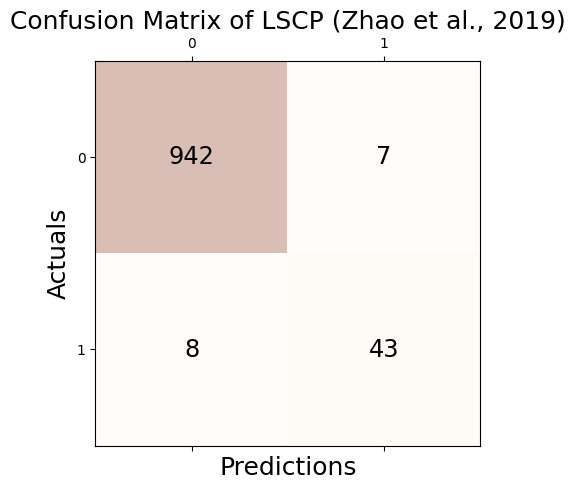

Accuracy: 0.985
Precision: 0.860
Recall: 0.843
F1 Score: 0.851

In [104]:
_conf = Conf_matrx(outlier_true_linear,outlier_LSCP_one)
_conf.conf("LSCP (Zhao et al., 2019)")

In [105]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.985
Precision(TP / TP + FP): 0.860
Recall(TP / TP + FN): 0.843
F1 Score(2*precision*recall/precision+recall): 0.851

In [106]:
fpr, tpr, thresh = roc_curve(outlier_true_linear,clf.decision_function(_df))

In [107]:
auc(fpr, tpr)

In [108]:
tab_linear = pd.concat([tab_linear,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_linear

## tab_linear

In [109]:
round(tab_linear,3)

# Orbit

In [110]:
# np.random.seed(1212)
# epsilon = np.around(np.random.normal(size=1000),15)
# signal = np.random.choice(np.concatenate((np.random.uniform(-7, -5, 25).round(15), np.random.uniform(5, 7, 25).round(15), np.repeat(0, 950))), 1000)
# eta = signal + epsilon
# np.random.seed(777)
# pi=np.pi
# n=1000
# ang=np.linspace(-pi,pi-2*pi/n,n)
# r=5+np.cos(np.linspace(0,12*pi,n))
# vx=r*np.cos(ang)
# vy=r*np.sin(ang)
# f1=10*np.sin(np.linspace(0,6*pi,n))
# f = f1 + eta
# _df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})
# outlier_true_orbit = signal.copy()
# outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))

In [111]:
tab_orbit = pd.DataFrame(columns=["Accuracy","Precision","Recall","F1","AUC"])

In [112]:
np.random.seed(777)
epsilon = np.around(np.random.normal(size=1000),15)
signal = np.random.choice(np.concatenate((np.random.uniform(-4, -1, 25).round(15), np.random.uniform(1, 4, 25).round(15), np.repeat(0, 950))), 1000)
eta = signal + epsilon
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=5+np.cos(np.linspace(0,12*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + eta
_df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f})
outlier_true_orbit = signal.copy()
outlier_true_orbit = list(map(lambda x: 1 if x!=0 else 0,outlier_true_orbit))

## GODE_Orbit

In [113]:
_Orbit = Orbit(_df)
_Orbit.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 595.48it/s]

In [114]:
_Orbit.get_weightmatrix(theta=(_Orbit.D[_Orbit.D>0].mean()),kappa=2500) 
_Orbit.fit(sd=15,ref=20)

In [115]:
outlier_GODE_one_old = (_Orbit.df['Residual']**2).tolist()
sorted_data = sorted(outlier_GODE_one_old,reverse=True)
index = int(len(sorted_data) * 0.05)
five_percent = sorted_data[index]
outlier_GODE_one = list(map(lambda x: 1 if x > five_percent else 0,outlier_GODE_one_old))

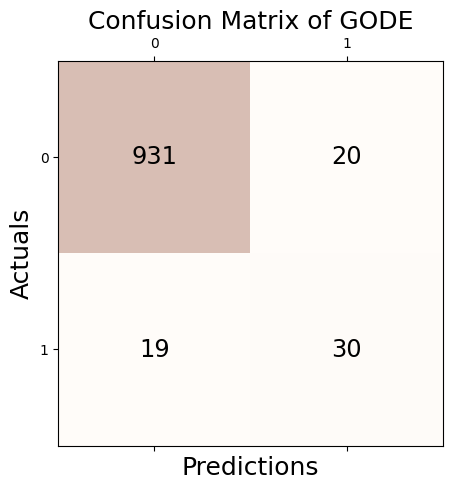

Accuracy: 0.961
Precision: 0.600
Recall: 0.612
F1 Score: 0.606

In [116]:
_conf = Conf_matrx(outlier_true_orbit,outlier_GODE_one)
_conf.conf("GODE")

In [117]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.961
Precision(TP / TP + FP): 0.600
Recall(TP / TP + FN): 0.612
F1 Score(2*precision*recall/precision+recall): 0.606

In [118]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,outlier_GODE_one_old)

In [119]:
auc(fpr, tpr)

In [120]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## LOF_Orbit

In [121]:
np.random.seed(77)
clf = LOF(contamination=0.05)
clf.fit(_df[['x', 'y','f']])

In [122]:
outlier_LOF_one = list(clf.labels_)

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)

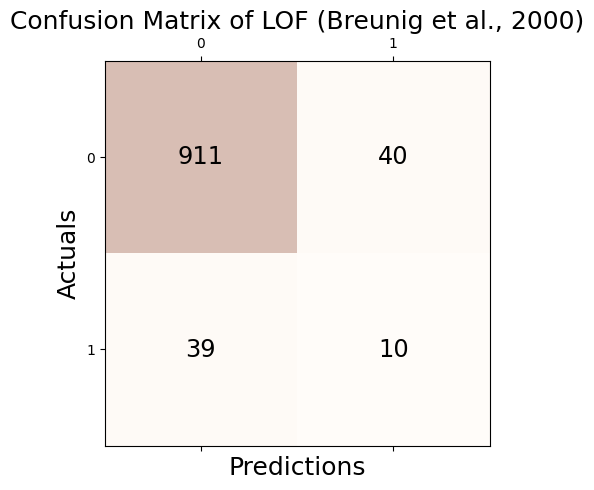

Accuracy: 0.921
Precision: 0.200
Recall: 0.204
F1 Score: 0.202

In [123]:
_conf = Conf_matrx(outlier_true_orbit,clf.fit_predict(_df))
_conf.conf("LOF (Breunig et al., 2000)")

In [124]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.921
Precision(TP / TP + FP): 0.200
Recall(TP / TP + FN): 0.204
F1 Score(2*precision*recall/precision+recall): 0.202

In [125]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

In [126]:
auc(fpr, tpr)

In [127]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## KNN_Orbit

In [128]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['x', 'y','f']])

In [129]:
outlier_KNN_one = list(clf.labels_)

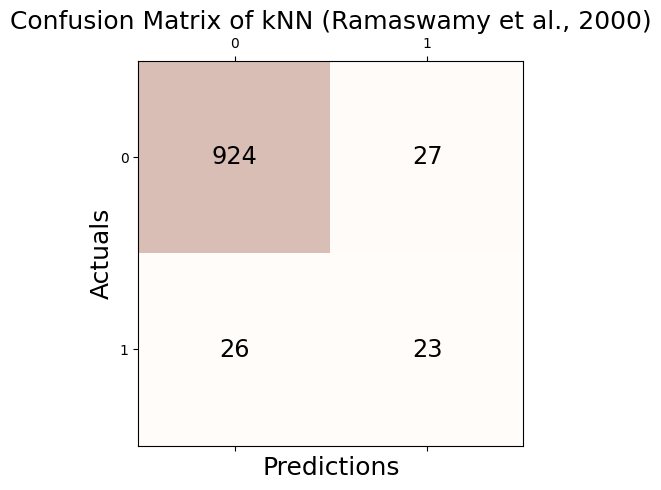

Accuracy: 0.947
Precision: 0.460
Recall: 0.469
F1 Score: 0.465

In [130]:
_conf = Conf_matrx(outlier_true_orbit,outlier_KNN_one)
_conf.conf("kNN (Ramaswamy et al., 2000)")

In [131]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.947
Precision(TP / TP + FP): 0.460
Recall(TP / TP + FN): 0.469
F1 Score(2*precision*recall/precision+recall): 0.465

In [132]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

In [133]:
auc(fpr, tpr)

In [134]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## CBLOF_Orbit

In [135]:
clf = CBLOF(contamination=0.05,random_state=77)
clf.fit(_df[['x', 'y','f']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)

In [136]:
outlier_CBLOF_one = list(clf.labels_)

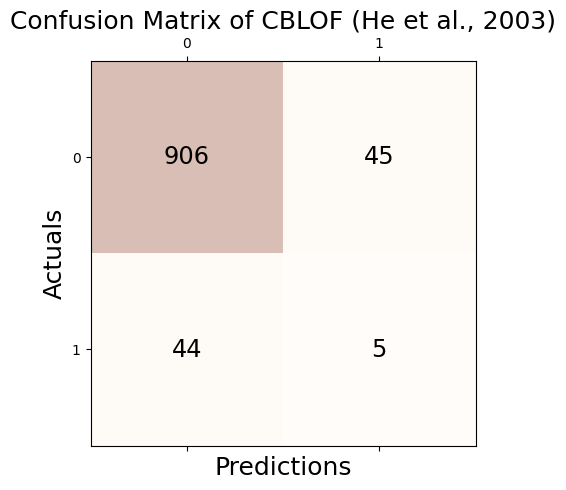

Accuracy: 0.911
Precision: 0.100
Recall: 0.102
F1 Score: 0.101

In [137]:
_conf = Conf_matrx(outlier_true_orbit,outlier_CBLOF_one)
_conf.conf("CBLOF (He et al., 2003)")

In [138]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.911
Precision(TP / TP + FP): 0.100
Recall(TP / TP + FN): 0.102
F1 Score(2*precision*recall/precision+recall): 0.101

In [139]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

In [140]:
auc(fpr, tpr)

In [141]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## OCSVM_Orbit

In [142]:
np.random.seed(77)
clf = OCSVM(nu=0.05)
clf.fit(_df)

In [143]:
outlier_OSVM_one = list(clf.predict(_df))

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(

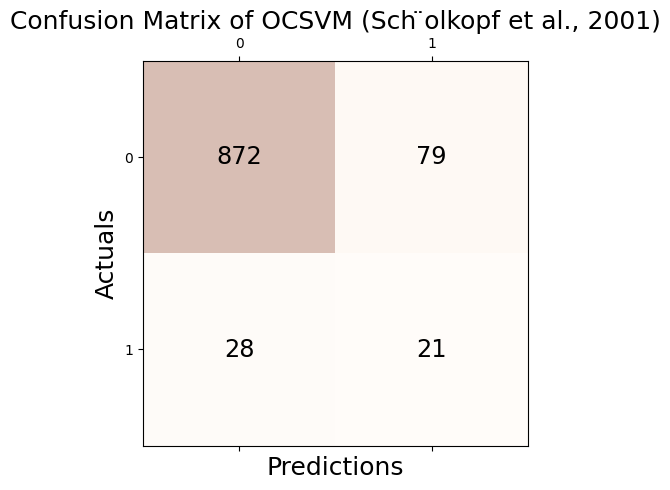

Accuracy: 0.893
Precision: 0.210
Recall: 0.429
F1 Score: 0.282

In [144]:
_conf = Conf_matrx(outlier_true_orbit,outlier_OSVM_one)
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

In [145]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.893
Precision(TP / TP + FP): 0.210
Recall(TP / TP + FN): 0.429
F1 Score(2*precision*recall/precision+recall): 0.282

In [146]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(

In [147]:
auc(fpr, tpr)

In [148]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## MCD_Orbit

In [149]:
clf = MCD(contamination=0.05 , random_state = 77)
clf.fit(_df[['x','y','f']])

In [150]:
outlier_MCD_one = list(clf.labels_)

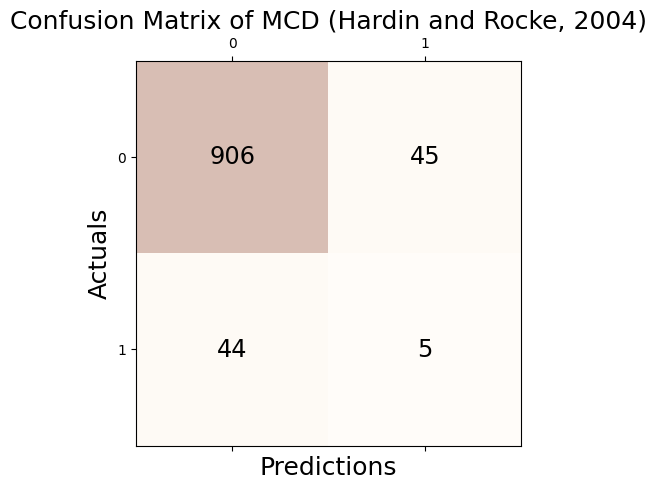

Accuracy: 0.911
Precision: 0.100
Recall: 0.102
F1 Score: 0.101

In [151]:
_conf = Conf_matrx(outlier_true_orbit,outlier_MCD_one)
_conf.conf("MCD (Hardin and Rocke, 2004)")

In [152]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.911
Precision(TP / TP + FP): 0.100
Recall(TP / TP + FN): 0.102
F1 Score(2*precision*recall/precision+recall): 0.101

In [153]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

In [154]:
auc(fpr, tpr)

In [155]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## Feature Bagging_Orbit

In [156]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','f']])

In [157]:
outlier_FeatureBagging_one = list(clf.labels_)

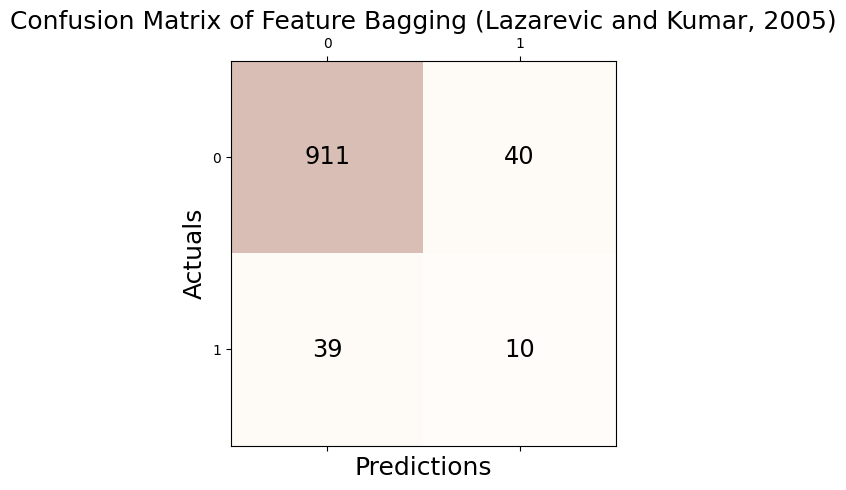

Accuracy: 0.921
Precision: 0.200
Recall: 0.204
F1 Score: 0.202

In [158]:
_conf = Conf_matrx(outlier_true_orbit,outlier_FeatureBagging_one)
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

In [159]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.921
Precision(TP / TP + FP): 0.200
Recall(TP / TP + FN): 0.204
F1 Score(2*precision*recall/precision+recall): 0.202

In [160]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

In [161]:
auc(fpr, tpr)

In [162]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## ABOD_Orbit

In [163]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','f']])

In [164]:
outlier_ABOD_one = list(clf.labels_)

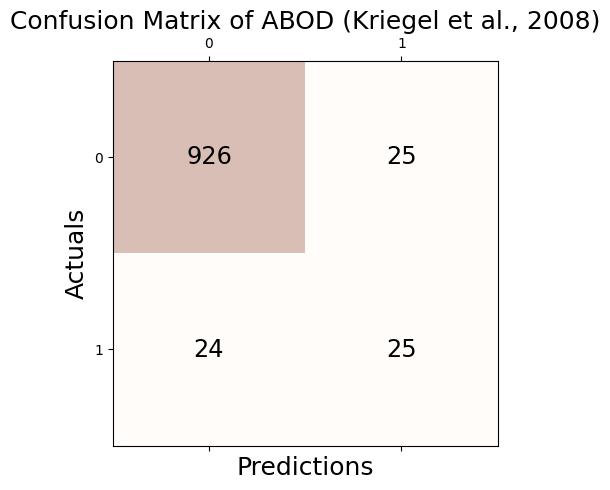

Accuracy: 0.951
Precision: 0.500
Recall: 0.510
F1 Score: 0.505

In [165]:
_conf = Conf_matrx(outlier_true_orbit,outlier_ABOD_one)
_conf.conf("ABOD (Kriegel et al., 2008)")

In [166]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.951
Precision(TP / TP + FP): 0.500
Recall(TP / TP + FN): 0.510
F1 Score(2*precision*recall/precision+recall): 0.505

In [167]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

In [168]:
auc(fpr, tpr)

In [169]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## IForest_Orbit

In [170]:
clf = IForest(contamination=0.05,random_state=77)
clf.fit(_df[['x', 'y','f']])

In [171]:
outlier_IForest_one = list(clf.labels_)

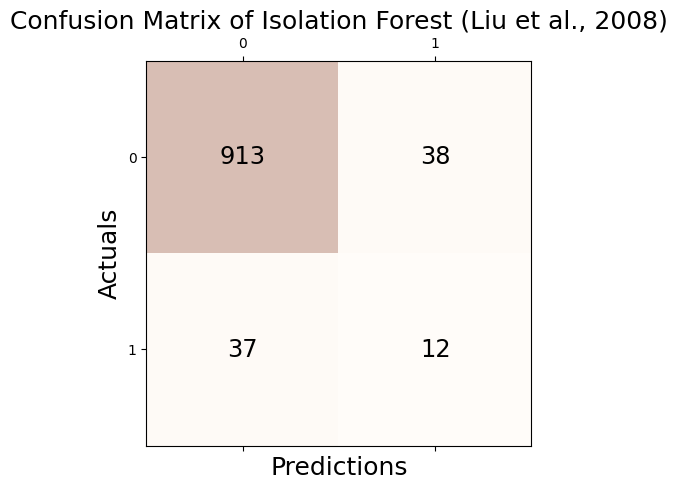

Accuracy: 0.925
Precision: 0.240
Recall: 0.245
F1 Score: 0.242

In [172]:
_conf = Conf_matrx(outlier_true_orbit,outlier_IForest_one)
_conf.conf("Isolation Forest (Liu et al., 2008)")

In [173]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.925
Precision(TP / TP + FP): 0.240
Recall(TP / TP + FN): 0.245
F1 Score(2*precision*recall/precision+recall): 0.242

In [174]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(

In [175]:
auc(fpr, tpr)

In [176]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## HBOS_Orbit

In [177]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['x', 'y','f']])

In [178]:
outlier_HBOS_one = list(clf.labels_)

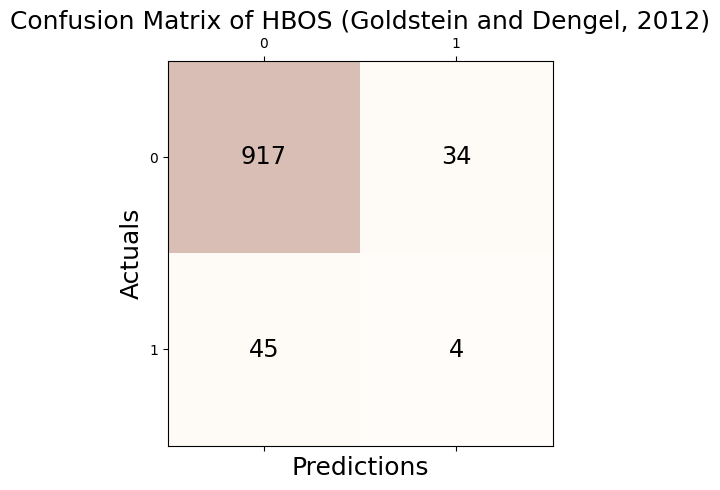

Accuracy: 0.921
Precision: 0.105
Recall: 0.082
F1 Score: 0.092

In [179]:
_conf = Conf_matrx(outlier_true_orbit,outlier_HBOS_one)
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

In [180]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.921
Precision(TP / TP + FP): 0.105
Recall(TP / TP + FN): 0.082
F1 Score(2*precision*recall/precision+recall): 0.092

In [181]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

In [182]:
auc(fpr, tpr)

In [183]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## SOS_Orbit

In [184]:
np.random.seed(77)
clf = SOS(contamination=0.05)
clf.fit(_df[['x', 'y','f']])

In [185]:
outlier_SOS_one = list(clf.labels_)

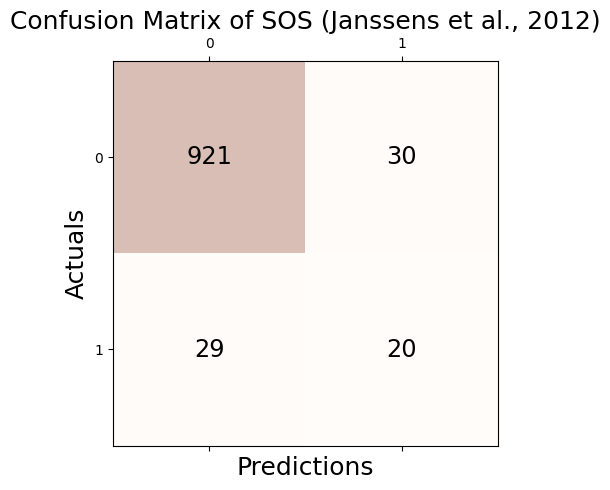

Accuracy: 0.941
Precision: 0.400
Recall: 0.408
F1 Score: 0.404

In [186]:
_conf = Conf_matrx(outlier_true_orbit,outlier_SOS_one)
_conf.conf("SOS (Janssens et al., 2012)")

In [187]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.941
Precision(TP / TP + FP): 0.400
Recall(TP / TP + FN): 0.408
F1 Score(2*precision*recall/precision+recall): 0.404

In [188]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

In [189]:
auc(fpr, tpr)

In [190]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## SO_GAAL_Orbit

In [191]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','f']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:
Epoch 7 of 60

Testing for epoch 7 index 1:

Testing for epoch 7 index 2:
Epoch 8 of 60

Testing for epoch 8 index 1:

Testing for epoch 8 index 2:
Epoch 9 of 60

Testing for epoch 9 index 1:

Testing for epoch 9 index 2:
Epoch 10 of 60

Testing for epoch 10 index 1:

Testing for epoch 10 index 2:
Epoch 11 of 60

Testing for epoch 11 index 1:

Testing for epoch 11 index 2:
Epoch 12 of 60

Testing for epoch 12 index 1:

Testing for epoch 12 index 2:
Epoch 13 of 60

Testing for epoch 13 index 1:

Testing for epoch 13 index 2:
Epoch 14 of 60

Testing fo

In [192]:
outlier_SO_GAAL_one = list(clf.labels_)

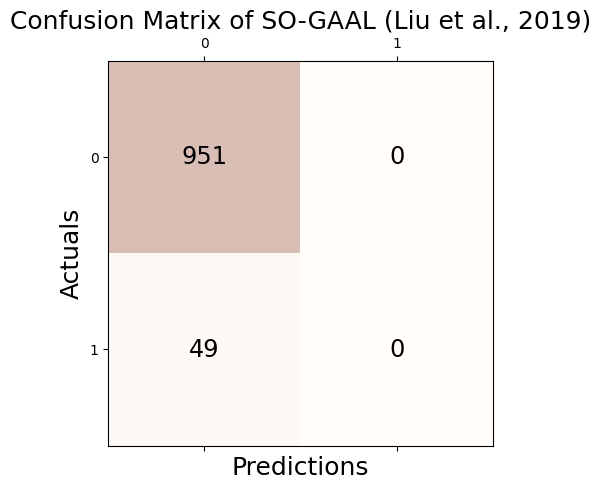

Accuracy: 0.951
Precision: 0.000
Recall: 0.000
F1 Score: 0.000

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

In [193]:
_conf = Conf_matrx(outlier_true_orbit,outlier_SO_GAAL_one)
_conf.conf("SO-GAAL (Liu et al., 2019)")

In [194]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.951
Precision(TP / TP + FP): nan
Recall(TP / TP + FN): 0.000
F1 Score(2*precision*recall/precision+recall): nan

/tmp/ipykernel_3852735/4166638268.py:3: RuntimeWarning: invalid value encountered in long_scalars
  print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
/tmp/ipykernel_3852735/4166638268.py:5: RuntimeWarning: invalid value encountered in long_scalars
  print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

In [195]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

32/32 [==============================] - 0s 568us/step

In [196]:
auc(fpr, tpr)

In [197]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## MO_GAAL_Orbit

In [198]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','f']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 1 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 2 of 60

Testing for epoch 2 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 2 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 3 of 60

Testing for epoch 3 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 3 index 2:
32/32 [==============================] - 0s 581us/step
Epoch 4 of 60

Testing for epoch 4 index 1:
32/32 [==============================] - 0s 583us/step

Testing for epoch 4 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 5 of 60

Testing for epoch 5 index 1:
32/32 [==============================] - 0s 1ms/step

Testing for epoch 5 index 2:
32/32 [==============================] - 0s 1ms/step
Epoch 6 of 60

Testing for epoch 6 index 1:
32/32 [==============================] - 0s 561us/st

In [199]:
outlier_MO_GAAL_one = list(clf.labels_)

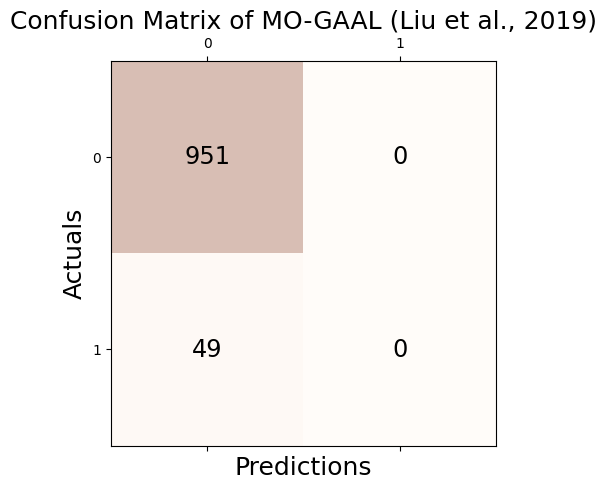

Accuracy: 0.951
Precision: 0.000
Recall: 0.000
F1 Score: 0.000

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

In [200]:
_conf = Conf_matrx(outlier_true_orbit,outlier_MO_GAAL_one)
_conf.conf("MO-GAAL (Liu et al., 2019)")

In [201]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.951
Precision(TP / TP + FP): nan
Recall(TP / TP + FN): 0.000
F1 Score(2*precision*recall/precision+recall): nan

/tmp/ipykernel_3852735/4166638268.py:3: RuntimeWarning: invalid value encountered in long_scalars
  print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
/tmp/ipykernel_3852735/4166638268.py:5: RuntimeWarning: invalid value encountered in long_scalars
  print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

In [202]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

32/32 [==============================] - 0s 557us/step

In [203]:
auc(fpr, tpr)

In [204]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## LSCP_Orbit

In [205]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','f']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(

In [206]:
outlier_LSCP_one = list(clf.labels_)

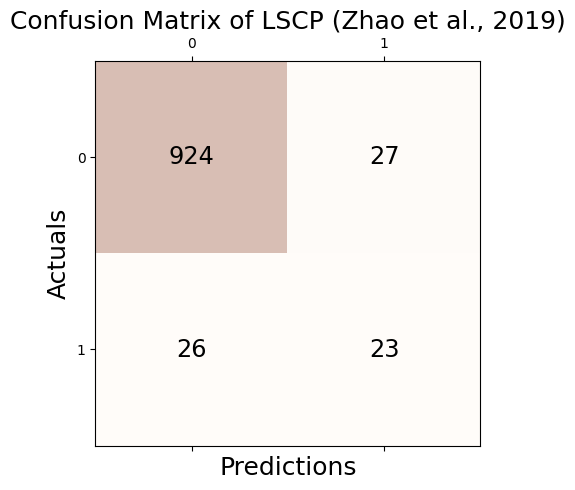

Accuracy: 0.947
Precision: 0.460
Recall: 0.469
F1 Score: 0.465

In [207]:
_conf = Conf_matrx(outlier_true_orbit,outlier_LSCP_one)
_conf.conf("LSCP (Zhao et al., 2019)")

In [208]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 0.947
Precision(TP / TP + FP): 0.460
Recall(TP / TP + FN): 0.469
F1 Score(2*precision*recall/precision+recall): 0.465

In [209]:
fpr, tpr, thresh = roc_curve(outlier_true_orbit,clf.decision_function(_df))

In [210]:
auc(fpr, tpr)

In [211]:
tab_orbit = pd.concat([tab_orbit,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_orbit

## tab_orbit

In [212]:
round(tab_orbit,3)

# Bunny

In [213]:
G = graphs.Bunny()
n = G.N
g = filters.Heat(G, tau=75) 
n=2503
np.random.seed(1212)
normal = np.around(np.random.normal(size=n),15)
unif = np.concatenate([np.random.uniform(low=3,high=7,size=60), np.random.uniform(low=-7,high=-3,size=60),np.zeros(n-120)]); np.random.shuffle(unif)
noise = normal + unif
f = np.zeros(n)
f[1000] = -3234
f = g.filter(f, method='chebyshev') 

2023-11-27 13:28:42,553:[WARNING](pygsp.graphs.graph.lmax): The largest eigenvalue G.lmax is not available, we need to estimate it. Explicitly call G.estimate_lmax() or G.compute_fourier_basis() once beforehand to suppress the warning.

In [214]:
G.coords.shape
_W = G.W.toarray()
_x = G.coords[:,0]
_y = G.coords[:,1]
_z = -G.coords[:,2]
_df1 = {'W':_W,'x':_x,'y':_y,'z':_z, 'fnoise':f+noise,'f' : f, 'noise': noise,'unif':unif}
_df = pd.DataFrame({'x': _df1['x'],'y':_df1['y'],'z':_df1['z'],'fnoise':_df1['fnoise'],'f':_df1['f'],'noise':_df1['noise']})
unif = _df1['unif']
outlier_true_bunny = unif.copy()
outlier_true_bunny = list(map(lambda x: 1 if x !=0  else 0,outlier_true_bunny))
X = np.array(_df)[:,:4]

## GODE_Bunny

In [215]:
_W = _df1['W']
_BUNNY = BUNNY(_df)
_BUNNY.fit(sd=20,ref=10)

In [216]:
outlier_GODE_one_old = (_BUNNY.df['Residual']**2).tolist()
sorted_data = sorted(outlier_GODE_one_old,reverse=True)
index = int(len(sorted_data) * 0.05)
five_percent = sorted_data[index]
outlier_GODE_one = list(map(lambda x: 1 if x > five_percent else 0,outlier_GODE_one_old))

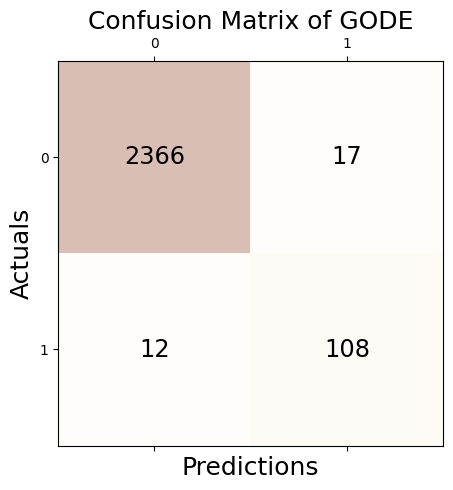

Accuracy: 0.988
Precision: 0.864
Recall: 0.900
F1 Score: 0.882

In [217]:
_conf = Conf_matrx(outlier_true_bunny,outlier_GODE_one)
_conf.conf("GODE")

In [218]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.474
Precision(TP / TP + FP): 0.864
Recall(TP / TP + FN): 0.900
F1 Score(2*precision*recall/precision+recall): 0.882

In [219]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,outlier_GODE_one_old)

In [220]:
auc(fpr, tpr)

In [221]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## LOF_Bunny

In [222]:
np.random.seed(77)
clf = LOF(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])

In [223]:
outlier_LOF_one = list(clf.labels_)

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)

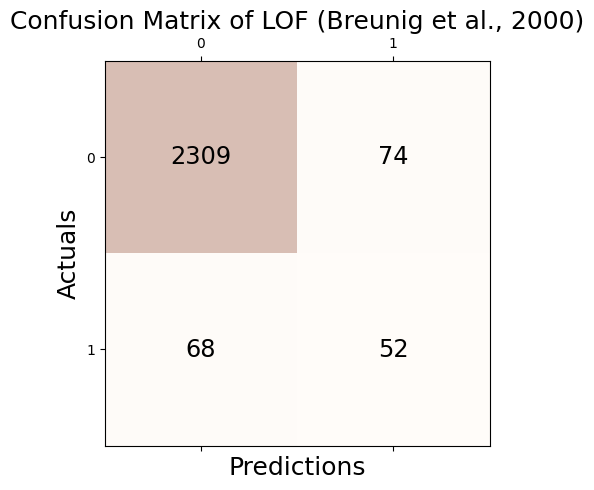

Accuracy: 0.943
Precision: 0.413
Recall: 0.433
F1 Score: 0.423

In [224]:
_conf = Conf_matrx(outlier_true_bunny,clf.fit_predict(X))
_conf.conf("LOF (Breunig et al., 2000)")

In [225]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.361
Precision(TP / TP + FP): 0.413
Recall(TP / TP + FN): 0.433
F1 Score(2*precision*recall/precision+recall): 0.423

In [226]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(X))

In [227]:
auc(fpr, tpr)

In [228]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## KNN_Bunny

In [229]:
np.random.seed(77)
clf = KNN(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])

In [230]:
outlier_KNN_one = list(clf.labels_)

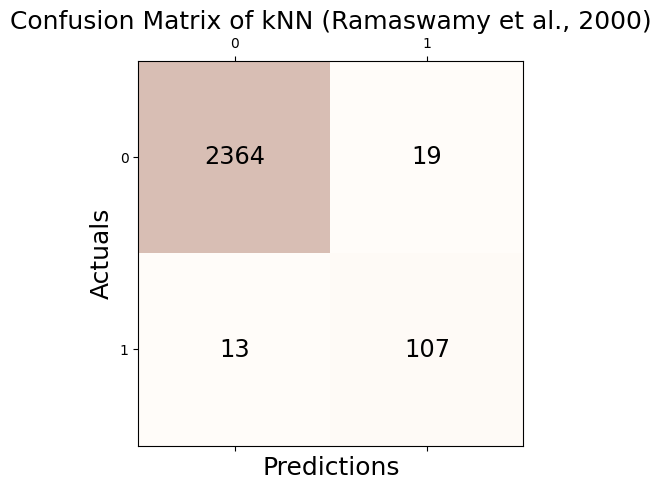

Accuracy: 0.987
Precision: 0.849
Recall: 0.892
F1 Score: 0.870

In [231]:
_conf = Conf_matrx(outlier_true_bunny,outlier_KNN_one)
_conf.conf("kNN (Ramaswamy et al., 2000)")

In [232]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.471
Precision(TP / TP + FP): 0.849
Recall(TP / TP + FN): 0.892
F1 Score(2*precision*recall/precision+recall): 0.870

In [233]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

In [234]:
auc(fpr, tpr)

In [235]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## CBLOF_Bunny

In [236]:
clf = CBLOF(contamination=0.05,random_state=77)
clf.fit(_df[['x', 'y','fnoise']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)

In [237]:
outlier_CBLOF_one = list(clf.labels_)

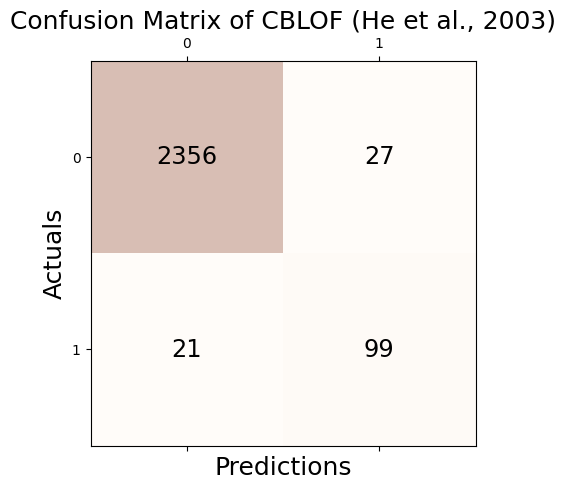

Accuracy: 0.981
Precision: 0.786
Recall: 0.825
F1 Score: 0.805

In [238]:
_conf = Conf_matrx(outlier_true_bunny,outlier_CBLOF_one)
_conf.conf("CBLOF (He et al., 2003)")

In [239]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.455
Precision(TP / TP + FP): 0.786
Recall(TP / TP + FN): 0.825
F1 Score(2*precision*recall/precision+recall): 0.805

In [240]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

In [241]:
auc(fpr, tpr)

In [242]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## OCSVM_Bunny

In [243]:
np.random.seed(77)
clf = OCSVM(nu=0.05)
clf.fit(X)

In [244]:
outlier_OSVM_one = list(clf.predict(X))

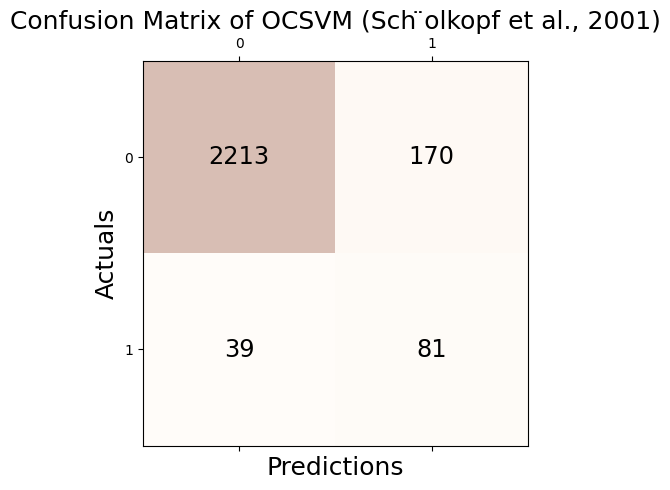

Accuracy: 0.917
Precision: 0.323
Recall: 0.675
F1 Score: 0.437

In [245]:
_conf = Conf_matrx(outlier_true_bunny,outlier_OSVM_one)
_conf.conf("OCSVM (Sch ̈olkopf et al., 2001)")

In [246]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.294
Precision(TP / TP + FP): 0.323
Recall(TP / TP + FN): 0.675
F1 Score(2*precision*recall/precision+recall): 0.437

In [247]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(X))

In [248]:
auc(fpr, tpr)

In [249]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## MCD_Bunny

In [250]:
clf = MCD(contamination=0.05 , random_state = 77)
clf.fit(_df[['x', 'y','fnoise']])

In [251]:
outlier_MCD_one = list(clf.labels_)

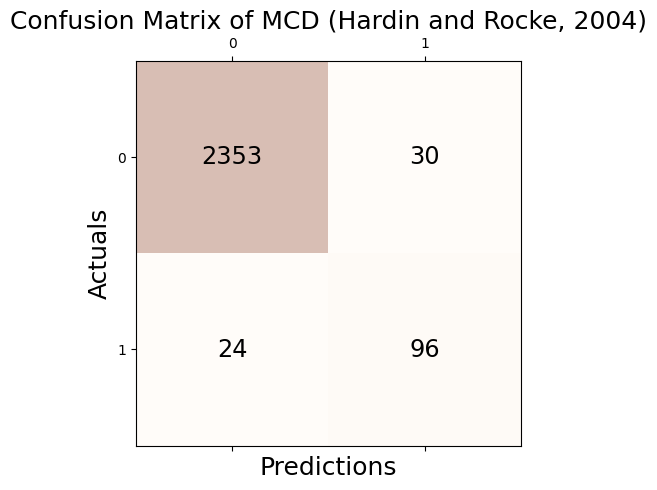

Accuracy: 0.978
Precision: 0.762
Recall: 0.800
F1 Score: 0.780

In [252]:
_conf = Conf_matrx(outlier_true_bunny,outlier_MCD_one)
_conf.conf("MCD (Hardin and Rocke, 2004)")

In [253]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.449
Precision(TP / TP + FP): 0.762
Recall(TP / TP + FN): 0.800
F1 Score(2*precision*recall/precision+recall): 0.780

In [254]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

In [255]:
auc(fpr, tpr)

In [256]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## Feature Bagging_Bunny

In [257]:
clf = FeatureBagging(contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','fnoise']])

In [258]:
outlier_FeatureBagging_one = list(clf.labels_)

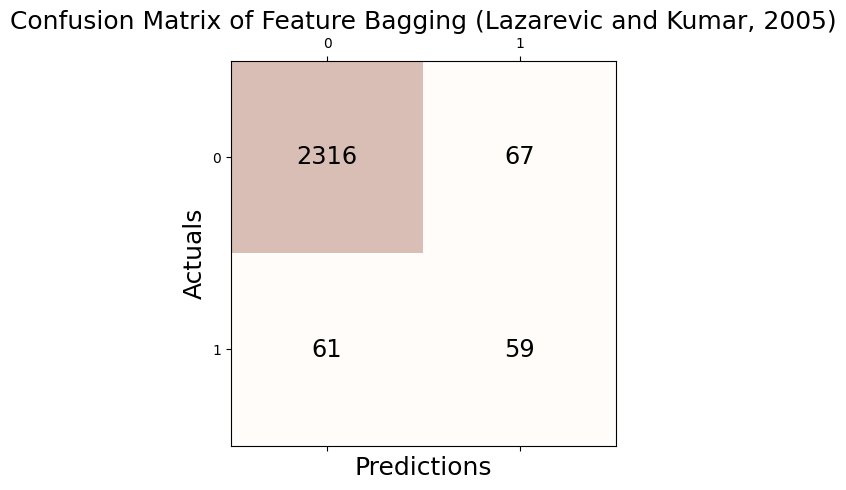

Accuracy: 0.949
Precision: 0.468
Recall: 0.492
F1 Score: 0.480

In [259]:
_conf = Conf_matrx(outlier_true_bunny,outlier_FeatureBagging_one)
_conf.conf("Feature Bagging (Lazarevic and Kumar, 2005)")

In [260]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.375
Precision(TP / TP + FP): 0.468
Recall(TP / TP + FN): 0.492
F1 Score(2*precision*recall/precision+recall): 0.480

In [261]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

In [262]:
auc(fpr, tpr)

In [263]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## ABOD_Bunny

In [264]:
np.random.seed(77)
clf = ABOD(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])

In [265]:
outlier_ABOD_one = list(clf.labels_)

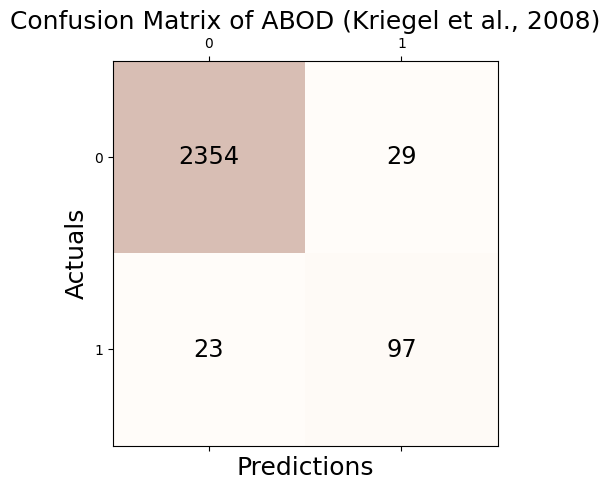

Accuracy: 0.979
Precision: 0.770
Recall: 0.808
F1 Score: 0.789

In [266]:
_conf = Conf_matrx(outlier_true_bunny,outlier_ABOD_one)
_conf.conf("ABOD (Kriegel et al., 2008)")

In [267]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.451
Precision(TP / TP + FP): 0.770
Recall(TP / TP + FN): 0.808
F1 Score(2*precision*recall/precision+recall): 0.789

In [268]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

In [269]:
auc(fpr, tpr)

In [270]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## IForest_Bunny

In [271]:
clf = IForest(contamination=0.05,random_state=77)
clf.fit(_df[['x', 'y','fnoise']])

In [272]:
outlier_IForest_one = list(clf.labels_)

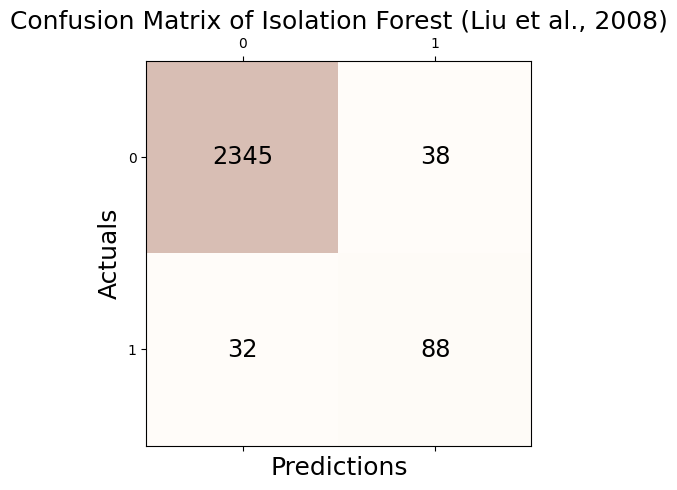

Accuracy: 0.972
Precision: 0.698
Recall: 0.733
F1 Score: 0.715

In [273]:
_conf = Conf_matrx(outlier_true_bunny,outlier_IForest_one)
_conf.conf("Isolation Forest (Liu et al., 2008)")

In [274]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.433
Precision(TP / TP + FP): 0.698
Recall(TP / TP + FN): 0.733
F1 Score(2*precision*recall/precision+recall): 0.715

In [275]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(

In [276]:
auc(fpr, tpr)

In [277]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## HBOS_Bunny

In [278]:
np.random.seed(77)
clf = HBOS(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])

In [279]:
outlier_HBOS_one = list(clf.labels_)

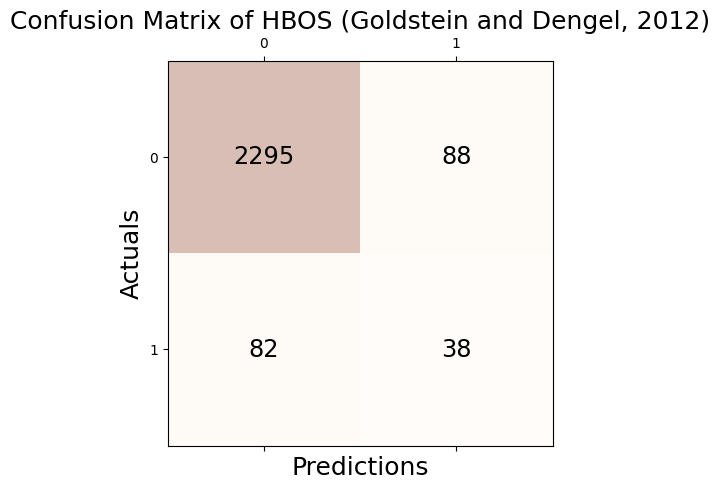

Accuracy: 0.932
Precision: 0.302
Recall: 0.317
F1 Score: 0.309

In [280]:
_conf = Conf_matrx(outlier_true_bunny,outlier_HBOS_one)
_conf.conf("HBOS (Goldstein and Dengel, 2012)")

In [281]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.333
Precision(TP / TP + FP): 0.302
Recall(TP / TP + FN): 0.317
F1 Score(2*precision*recall/precision+recall): 0.309

In [282]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

In [283]:
auc(fpr, tpr)

In [284]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## SOS_Bunny

In [285]:
np.random.seed(77)
clf = SOS(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])

In [286]:
outlier_SOS_one = list(clf.labels_)

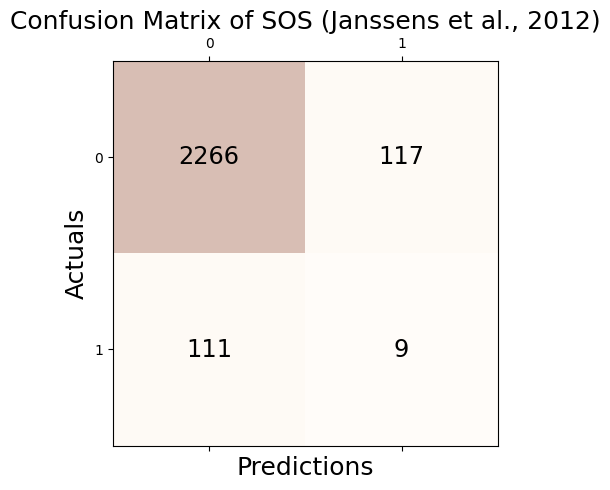

Accuracy: 0.909
Precision: 0.071
Recall: 0.075
F1 Score: 0.073

In [287]:
_conf = Conf_matrx(outlier_true_bunny,outlier_SOS_one)
_conf.conf("SOS (Janssens et al., 2012)")

In [288]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.275
Precision(TP / TP + FP): 0.071
Recall(TP / TP + FN): 0.075
F1 Score(2*precision*recall/precision+recall): 0.073

In [289]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

In [290]:
auc(fpr, tpr)

In [291]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## SO_GAAL_Bunny

In [292]:
np.random.seed(77)
clf = SO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:

Testing for epoch 1 index 2:

Testing for epoch 1 index 3:

Testing for epoch 1 index 4:

Testing for epoch 1 index 5:
Epoch 2 of 60

Testing for epoch 2 index 1:

Testing for epoch 2 index 2:

Testing for epoch 2 index 3:

Testing for epoch 2 index 4:

Testing for epoch 2 index 5:
Epoch 3 of 60

Testing for epoch 3 index 1:

Testing for epoch 3 index 2:

Testing for epoch 3 index 3:

Testing for epoch 3 index 4:

Testing for epoch 3 index 5:
Epoch 4 of 60

Testing for epoch 4 index 1:

Testing for epoch 4 index 2:

Testing for epoch 4 index 3:

Testing for epoch 4 index 4:

Testing for epoch 4 index 5:
Epoch 5 of 60

Testing for epoch 5 index 1:

Testing for epoch 5 index 2:

Testing for epoch 5 index 3:

Testing for epoch 5 index 4:

Testing for epoch 5 index 5:
Epoch 6 of 60

Testing for epoch 6 index 1:

Testing for epoch 6 index 2:

Testing for epoch 6 index 3:

Testing for epoch 6 index 4:

Testing for epoch 6 index 5:
Epoch 7 of 60

T

In [293]:
outlier_SO_GAAL_one = list(clf.labels_)

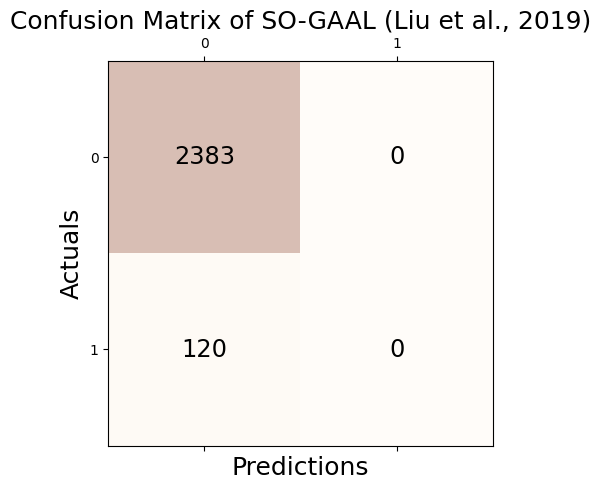

Accuracy: 0.952
Precision: 0.000
Recall: 0.000
F1 Score: 0.000

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

In [294]:
_conf = Conf_matrx(outlier_true_bunny,outlier_SO_GAAL_one)
_conf.conf("SO-GAAL (Liu et al., 2019)")

In [295]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.383
Precision(TP / TP + FP): nan
Recall(TP / TP + FN): 0.000
F1 Score(2*precision*recall/precision+recall): nan

/tmp/ipykernel_3852735/4166638268.py:3: RuntimeWarning: invalid value encountered in long_scalars
  print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
/tmp/ipykernel_3852735/4166638268.py:5: RuntimeWarning: invalid value encountered in long_scalars
  print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

In [296]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

79/79 [==============================] - 0s 527us/step

In [297]:
auc(fpr, tpr)

In [298]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## MO_GAAL_Bunny

In [299]:
np.random.seed(77)
clf = MO_GAAL(contamination=0.05)
clf.fit(_df[['x', 'y','fnoise']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)

Epoch 1 of 60

Testing for epoch 1 index 1:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 1 index 2:
79/79 [==============================] - 0s 2ms/step

Testing for epoch 1 index 3:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 1 index 4:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 1 index 5:
79/79 [==============================] - 0s 822us/step
Epoch 2 of 60

Testing for epoch 2 index 1:
79/79 [==============================] - 0s 556us/step

Testing for epoch 2 index 2:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 2 index 3:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 2 index 4:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 2 index 5:
79/79 [==============================] - 0s 1ms/step
Epoch 3 of 60

Testing for epoch 3 index 1:
79/79 [==============================] - 0s 1ms/step

Testing for epoch 3 index 2:
79/79 [====

In [300]:
outlier_MO_GAAL_one = list(clf.labels_)

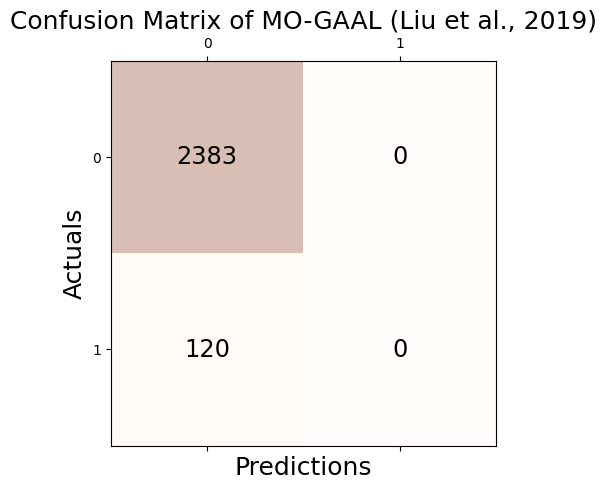

Accuracy: 0.952
Precision: 0.000
Recall: 0.000
F1 Score: 0.000

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

In [301]:
_conf = Conf_matrx(outlier_true_bunny,outlier_MO_GAAL_one)
_conf.conf("MO-GAAL (Liu et al., 2019)")

In [302]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.383
Precision(TP / TP + FP): nan
Recall(TP / TP + FN): 0.000
F1 Score(2*precision*recall/precision+recall): nan

/tmp/ipykernel_3852735/4166638268.py:3: RuntimeWarning: invalid value encountered in long_scalars
  print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
/tmp/ipykernel_3852735/4166638268.py:5: RuntimeWarning: invalid value encountered in long_scalars
  print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

In [303]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

79/79 [==============================] - 0s 1ms/step

In [304]:
auc(fpr, tpr)

In [305]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## LSCP_Bunny

In [306]:
detectors = [KNN(), LOF(), OCSVM()]
clf = LSCP(detectors,contamination=0.05, random_state=77)
clf.fit(_df[['x', 'y','fnoise']])

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/pyod/models/lscp.py:382: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  warnings.warn(

In [307]:
outlier_LSCP_one = list(clf.labels_)

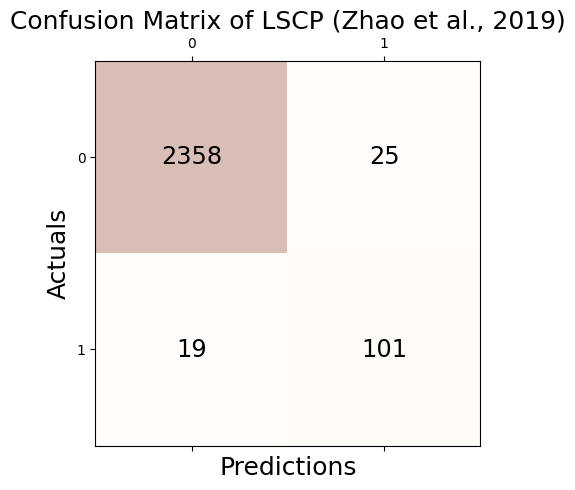

Accuracy: 0.982
Precision: 0.802
Recall: 0.842
F1 Score: 0.821

In [308]:
_conf = Conf_matrx(outlier_true_bunny,outlier_LSCP_one)
_conf.conf("LSCP (Zhao et al., 2019)")

In [309]:
# check
print('Accuracy(TP + TN / TP + TN + FP + FN): %.3f' % round((_conf.conf_matrix[0][0] + _conf.conf_matrix[1][1])/1000,3))
print('Precision(TP / TP + FP): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]),3))
print('Recall(TP / TP + FN): %.3f' % round(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]),3))
print('F1 Score(2*precision*recall/precision+recall): %.3f' % round((2*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]))*(_conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1]))) / (_conf.conf_matrix[1][1]/(_conf.conf_matrix[0][1] + _conf.conf_matrix[1][1]) + _conf.conf_matrix[1][1]/(_conf.conf_matrix[1][0] + _conf.conf_matrix[1][1])),3))

Accuracy(TP + TN / TP + TN + FP + FN): 2.459
Precision(TP / TP + FP): 0.802
Recall(TP / TP + FN): 0.842
F1 Score(2*precision*recall/precision+recall): 0.821

In [310]:
fpr, tpr, thresh = roc_curve(outlier_true_bunny,clf.decision_function(_df[['x', 'y','fnoise']]))

/home/csy/anaconda3/envs/pygsp/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())

In [311]:
auc(fpr, tpr)

In [312]:
tab_bunny = pd.concat([tab_bunny,
           pd.DataFrame({"Accuracy":[_conf.acc],"Precision":[_conf.pre],"Recall":[_conf.rec],"F1":[_conf.f1],"AUC":[auc(fpr, tpr)]},index = [_conf.name])]);tab_bunny

## tab_bunny

In [313]:
round(tab_bunny,3)